# 🛠️ Instalación de dependencias (versiones compatibles)

⚠️ IMPORTANTE:
Es obligatorio instalar estas versiones específicas de las librerías para garantizar la compatibilidad entre ellas. Usar versiones diferentes puede provocar errores durante la ejecución.

In [ ]:
!pip install -q --upgrade pip
!pip install numpy==1.23.5
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 -f https://download.pytorch.org/whl/cu121
!pip install monai==1.4.0 torchio==0.20.2 vtk==9.3.0 nibabel==5.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 105.7 MB/s  0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in links: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 21.7 MB/s  0:00:17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 97.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 57.9 MB/s  0:00:05
 

# 📦 Verificación de versiones instaladas
✅ Esta celda sirve para comprobar que las versiones de las librerías instaladas coinciden con las requeridas.

In [ ]:
import torch
import torchio as tio
import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

print("Torch version:", torch.__version__)
print("TorchIO version:", tio.__version__)
print("VTK version:", vtk.vtkVersion().GetVTKVersion())

Torch version: 2.2.2+cu121
TorchIO version: 0.20.2
VTK version: 9.3.0


# 📂 Montaje de Google Drive y definición de rutas
🔗 En esta celda montamos Google Drive para acceder a los archivos necesarios del proyecto.
Se definen tres rutas principales que se usarán a lo largo del código:

*  **data_dir:** contiene las imágenes y máscaras (por ejemplo, Study.vtk y las máscaras por parte del corazón).
*   **outputs_dir:** carpeta donde se guardarán los resultados generados, como las predicciones, modelos 3D, visualizaciones, etc.
*  **models_dir:** carpeta donde se almacenan los modelos entrenados y sus gráficas de entrenamiento.

Asegúrate de que las carpetas existen en tu Drive antes de continuar.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/tfm_alvaro/data"
outputs_dir = "/content/drive/MyDrive/tfm_alvaro/output"
models_dir = "/content/drive/MyDrive/tfm_alvaro/models"

Mounted at /content/drive


# 🧩 Importación de librerías necesarias

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import vtk
import os
from monai.networks.nets import UNet

# 📥 Lectura de archivos VTK como volúmenes 3D
Esta función permite cargar un archivo .vtk que representa un volumen estructurado y lo convierte en un array de NumPy en formato (Z, Y, X) para su posterior uso en el modelo.

In [ ]:
def read_vtk_volume(path):
    # Crear un lector VTK para archivos Structured Points (.vtk)
    reader = vtk.vtkStructuredPointsReader()
    # Establecer la ruta del archivo a leer
    reader.SetFileName(path)
    # Ejecutar el proceso de lectura
    reader.Update()
    # Obtener los datos de imagen resultantes del lector
    image = reader.GetOutput()
    # Obtener las dimensiones de la imagen (x, y, z)
    dims = image.GetDimensions()
    # Extraer los datos escalares (valores de los voxeles) como un array numpy plano
    scalars = vtk_to_numpy(image.GetPointData().GetScalars())
    # Remodelar el array plano en un volumen 3D con forma (z, y, x)
    volume = scalars.reshape(dims[::-1])
    # Convertir el volumen a un array numpy de tipo float32 para su procesamiento
    return volume.astype(np.float32), image

# 🧠 Carga de un modelo UNet entrenado
Esta función inicializa una red neuronal 3D UNet de MONAI y carga sus pesos entrenados desde un archivo. La red se configura para evaluación (modo eval) y se mueve al dispositivo correcto (CPU o GPU).

In [1]:
def load_model(model_path, device):
    # Crear una instancia de la red UNet 3D con los parámetros especificados
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2
    ).to(device)
    # Cargar los pesos guardados del modelo desde el archivo indicad
    model.load_state_dict(torch.load(model_path, map_location=device))
    # Poner el modelo en modo evaluación (desactiva dropout, batchnorm en modo entrenamiento, etc.)
    model.eval()
    return model

# 🖼️ Visualización de predicciones sobre cortes axiales del volumen
Esta función permite visualizar diferentes cortes axiales (slices) del volumen 3D, mostrando:

1.   La imagen original
2.   La máscara real (ground truth)
3.   La predicción realizada por la red neuronal

Si step es None, solo se muestra el corte central. En caso contrario, se generan imágenes cada cierto número de cortes (step).

In [ ]:
"""
def show_prediction_slices(image, target, pred_mask, step=None):
    if step is None:
        slice_idxs = [image.shape[0] // 2]
    else:
        slice_idxs = list(range(0, image.shape[0], step))

    num_slices = len(slice_idxs)
    plt.figure(figsize=(20, 5 * num_slices))

    for i, idx in enumerate(slice_idxs):
        # 1. Imagen original
        plt.subplot(num_slices, 4, i * 4 + 1)
        plt.imshow(image[idx], cmap='gray', vmin=0, vmax=1)
        plt.title(f"Original - Slice {idx}")
        plt.axis('off')

        # 2. Máscara real
        plt.subplot(num_slices, 4, i * 4 + 2)
        plt.imshow(target[idx], cmap='Reds', vmin=0, vmax=1)
        plt.title(f"Máscara Real - Slice {idx}")
        plt.axis('off')

        # 3. Predicción
        plt.subplot(num_slices, 4, i * 4 + 3)
        plt.imshow(pred_mask[idx], cmap='Blues', vmin=0, vmax=1)
        plt.title(f"Predicción - Slice {idx}")
        plt.axis('off')

        # 4. Superposición sin blanquear
        plt.subplot(num_slices, 4, i * 4 + 4)
        plt.imshow(image[idx], cmap='gray', vmin=0, vmax=1)
        plt.imshow(target[idx], cmap='Reds', alpha=0.4, vmin=0, vmax=1)
        plt.imshow(pred_mask[idx], cmap='Blues', alpha=0.4, vmin=0, vmax=1)
        plt.title(f"Superposición - Slice {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

"""
def show_prediction_slices(image, target, pred_mask, step=None):
    """
    Muestra cortes de la resonancia con:
    - Máscara real (rojo puro)
    - Predicción (azul puro)
    - Superposición de ambas sobre la imagen original
    """
    if step is None:
        slice_idxs = [image.shape[0] // 2]
    else:
        slice_idxs = list(range(0, image.shape[0], step))

    num_slices = len(slice_idxs)
    plt.figure(figsize=(20, 5 * num_slices))

    for i, idx in enumerate(slice_idxs):
        img_slice = image[idx]
        img_rgb = np.stack([img_slice]*3, axis=-1)  # [Y, X, 3]

        # Normalizar si es necesario
        if img_rgb.max() > 1:
            img_rgb = img_rgb / img_rgb.max()

        # Crear una copia de la imagen para superponer
        overlay_real = img_rgb.copy()
        overlay_pred = img_rgb.copy()
        overlay_both = img_rgb.copy()

        # === Aplicar máscara real (rojo) ===
        mask = target[idx] > 0.5
        overlay_real[mask, 0] = 1.0   # rojo
        overlay_real[mask, 1] = 0.0
        overlay_real[mask, 2] = 0.0

        # === Aplicar predicción (azul) ===
        pred = pred_mask[idx] > 0.5
        overlay_pred[pred, 0] = 0.0
        overlay_pred[pred, 1] = 0.0
        overlay_pred[pred, 2] = 1.0

        # === Superposición (rojo y azul)
        overlay_both[mask, 0] = 1.0  # rojo donde hay máscara real
        overlay_both[mask, 1] = 0.0
        overlay_both[mask, 2] = 0.0
        overlay_both[pred, 0] = 0.0  # azul donde hay predicción
        overlay_both[pred, 1] = 0.0
        overlay_both[pred, 2] = 1.0

        # Mostrar imágenes
        plt.subplot(num_slices, 4, i * 4 + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original - Slice {idx}")
        plt.axis('off')

        plt.subplot(num_slices, 4, i * 4 + 2)
        plt.imshow(overlay_real)
        plt.title("Máscara Real (Rojo)")
        plt.axis('off')

        plt.subplot(num_slices, 4, i * 4 + 3)
        plt.imshow(overlay_pred)
        plt.title("Predicción (Azul)")
        plt.axis('off')

        plt.subplot(num_slices, 4, i * 4 + 4)
        plt.imshow(overlay_both)
        plt.title("Superposición")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# 💾 Guardar la predicción como volumen .vtk
Esta función convierte una máscara de predicción 3D en formato NumPy a un archivo VTK estructurado (volumen) para su visualización o análisis posterior. El formato mantiene la estructura del volumen original.

In [5]:
def save_prediction_as_vtk_volume(prediction, output_path, reference_image):

    # Convertir la predicción a tipo float32 para asegurar compatibilidad
    prediction = prediction.astype(np.float32)

    # Obtener las dimensiones del volumen y reordenarlas de (Z, Y, X) a (X, Y, Z) para VTK
    dims = prediction.shape[::-1]

    # Aplanar los datos en orden C (z, y, x) porque VTK espera este orden
    flat_data = prediction.ravel(order='C')

    # Convertir el array numpy a un array compatible con VTK
    vtk_data = numpy_to_vtk(flat_data, deep=True, array_type=vtk.VTK_FLOAT)

    # Crear un objeto vtkImageData que contendrá el volumen
    image_data = vtk.vtkImageData()
    # Establecer las dimensiones en el orden correcto
    image_data.SetDimensions(*dims)
    # Asignar los datos escalares al volumen
    image_data.GetPointData().SetScalars(vtk_data)

    # Para que salgan con el mismo origen de cordendas espaciales y centradas
    image_data.SetOrigin(reference_image.GetOrigin())
    image_data.SetSpacing(reference_image.GetSpacing())

    # Crear un escritor para guardar el volumen en formato VTK StructuredPoints
    writer = vtk.vtkStructuredPointsWriter()
    writer.SetFileName(output_path)
    writer.SetInputData(image_data)
    writer.Write()

    print(f"[INFO] predicted volume exported as VTK model in: {output_path}")

# 🧱 Guardar la predicción como modelo 3D (malla)
Esta función convierte una predicción binaria en una malla de superficie usando el algoritmo de Marching Cubes, y guarda el resultado como un modelo 3D en formato .vtk. Es útil para visualizar estructuras segmentadas como si fueran un objeto sólido.

In [6]:
def save_prediction_as_vtk_3d_model(prediction, output_path, reference_image):
    prediction = prediction.astype(np.float32)
    dims = prediction.shape[::-1]
    flat_data = prediction.ravel(order='C')
    vtk_data = numpy_to_vtk(flat_data, deep=True, array_type=vtk.VTK_FLOAT)

    image_data = vtk.vtkImageData()
    image_data.SetDimensions(*dims)
    image_data.GetPointData().SetScalars(vtk_data)

    # 🧠 Copiar metadatos espaciales
    # image_data.SetOrigin(reference_image.GetOrigin())
    # image_data.SetSpacing(reference_image.GetSpacing())
    # image_data.SetExtent(reference_image.GetExtent())

    contour = vtk.vtkMarchingCubes()
    contour.SetInputData(image_data)
    contour.SetValue(0, 0.5)
    contour.Update()

    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_path)
    writer.SetInputData(contour.GetOutput())
    writer.Write()

    print(f"[INFO] 3D model exported as VTK model in: {output_path}")

# ⚙️ Diccionario de configuración
Esta lista contiene las distintas regiones del corazón que se pueden procesar, junto con una bandera booleana que indica si se deben incluir en la ejecución actual.

In [ ]:
heart_parts = [
    ("LV", True),
    ("LV_Epi", False),
    ("RV_Epi", False),
    ("LV_Endo", False),
    ("RV_Endo", False),
    ("Core_Surface", False),
    ("Border_Zone_Surface", False)
]

# 🧠 Ejecución principal (main)

Este bloque recorre todas las estructuras del corazón activadas en el diccionario `heart_parts` y hace todo el proceso:

1. Carga las imágenes y máscaras desde archivos `.vtk`.
2. Normaliza la imagen y la convierte a tensor.
3. Carga el modelo entrenado correspondiente.
4. Realiza la predicción de la segmentación.
5. Guarda los resultados como volumen `.vtk` y como modelo 3D.
6. Muestra cortes visuales de la imagen, máscara real y predicción.

Todo está automatizado. Solo asegúrate de tener los datos, modelos y carpetas correctamente ubicados.

###################################################################
                         LV
###################################################################
[INFO] Loading model...
[INFO] Procesando paciente: paciente4
[INFO] Loading .vtk volumes...
[INFO] Making the prediction...
[INFO] predicted volume exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente4/segmented_prediction_LV.vtk
[INFO] 3D model exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente4/3Dmodel_prediction_LV.vtk
[INFO] Showing results...


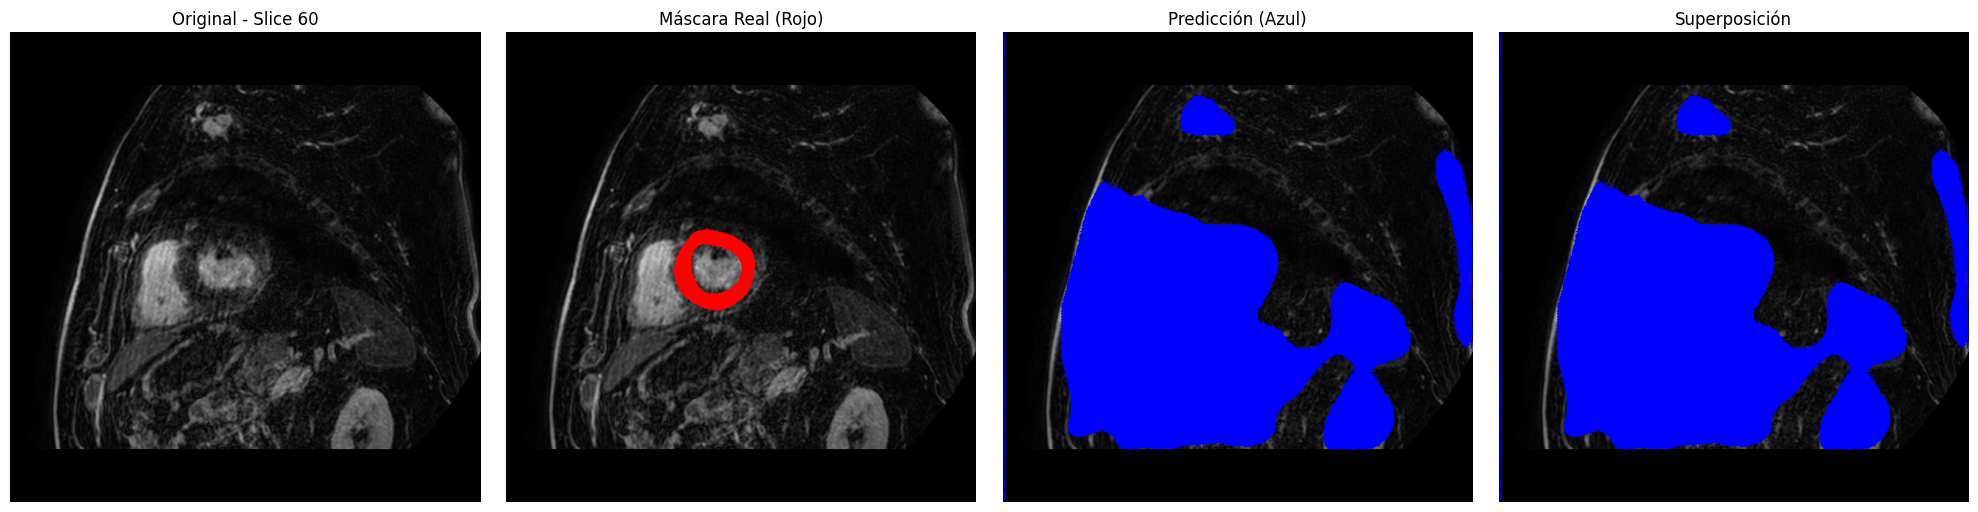



[INFO] Procesando paciente: paciente3
[INFO] Loading .vtk volumes...
[INFO] Making the prediction...
[INFO] predicted volume exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente3/segmented_prediction_LV.vtk
[INFO] 3D model exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente3/3Dmodel_prediction_LV.vtk
[INFO] Showing results...


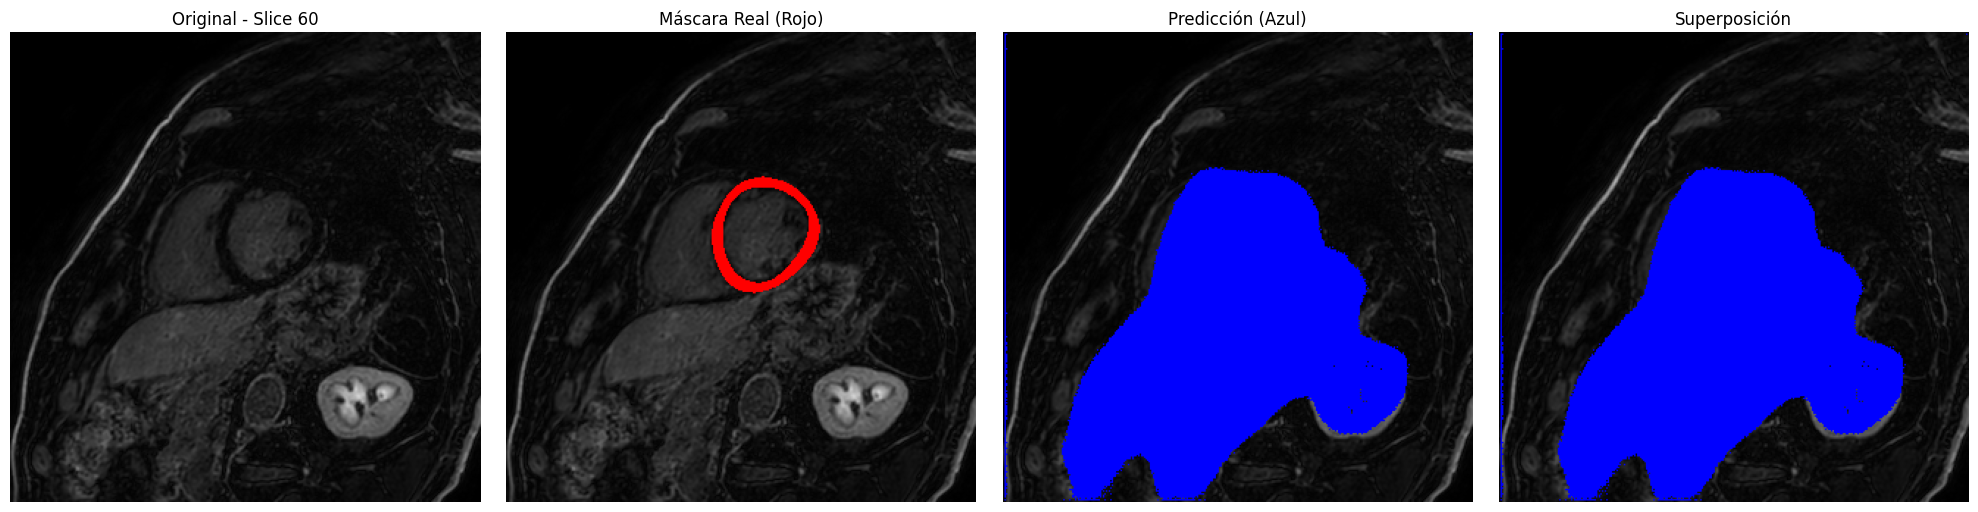



[INFO] Procesando paciente: paciente1
[INFO] Loading .vtk volumes...
[INFO] Making the prediction...
[INFO] predicted volume exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente1/segmented_prediction_LV.vtk
[INFO] 3D model exported as VTK model in: /content/drive/MyDrive/tfm_alvaro/output/LV/paciente1/3Dmodel_prediction_LV.vtk
[INFO] Showing results...


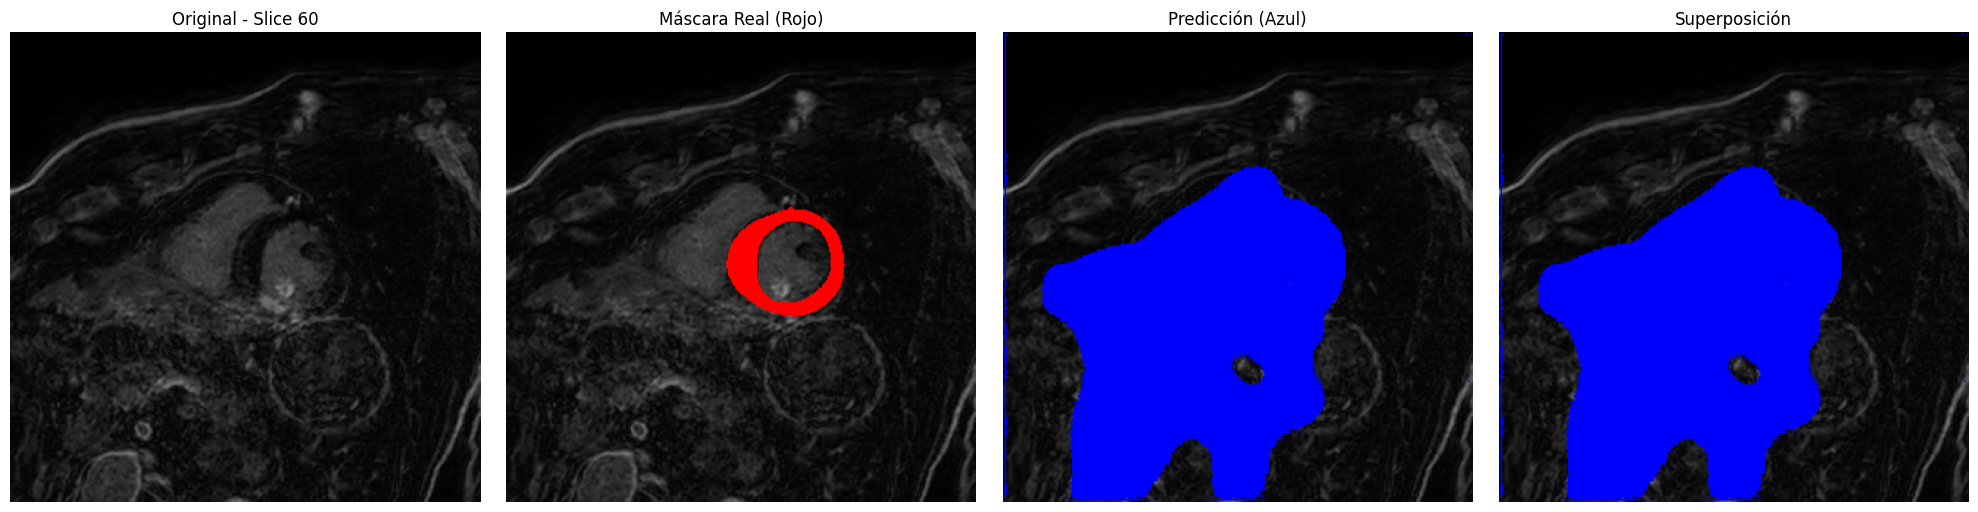



[INFO] Done!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Agregamos la función para hacer padding en el tensor
import torch.nn.functional as F

def pad_tensor(tensor, divisor=8):
    """
    Recibe un tensor de forma [N, C, D, H, W] o [C, D, H, W] y aplica padding
    simétrico para que las dimensiones D, H y W sean múltiplos de 'divisor'.
    """
    if tensor.dim() == 5:
        _, c, d, h, w = tensor.shape
    else:
        c, d, h, w = tensor.shape

    pad_d = (divisor - d % divisor) % divisor
    pad_h = (divisor - h % divisor) % divisor
    pad_w = (divisor - w % divisor) % divisor

    padding = (
        pad_w // 2, pad_w - pad_w // 2,
        pad_h // 2, pad_h - pad_h // 2,
        pad_d // 2, pad_d - pad_d // 2,
    )
    return F.pad(tensor, padding, mode='constant', value=0)

# Recorremos el diccionario de configuración
for heart_part, flag in heart_parts:

    # Por cada modelo que queremos evaluar que esté activo (flag = True)
    if not flag:
        continue

    print("###################################################################")
    print(f"                         {heart_part}")
    print("###################################################################")

    # Cargar modelo entrenado
    model_path = os.path.join(models_dir, heart_part, f"model_3dunet_{heart_part}.pth")
    print("[INFO] Loading model...")
    model = load_model(model_path, device)

    # Recorrer carpetas de pacientes
    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        print(f"[INFO] Procesando paciente: {patient_folder}")

        # Definir rutas de imagen y máscara para este paciente
        image_path = os.path.join(patient_path, "Study.vtk")
        mask_path = os.path.join(patient_path, f"Mask_Image_{heart_part}.vtk")
        output_dir = os.path.join(outputs_dir, heart_part, patient_folder)
        os.makedirs(output_dir, exist_ok=True)

        # Verificar que los archivos existen
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"[WARNING] Faltan archivos para {patient_folder}, se omite.")
            continue

        # Cargar volúmenes VTK de imagen y máscara
        print("[INFO] Loading .vtk volumes...")
        image_np, image_vtk = read_vtk_volume(image_path)
        mask_np, _ = read_vtk_volume(mask_path)

        # Normalizar imagen
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        # Convertir a tensores y mover a GPU si está disponible
        image_tensor = torch.tensor(image_np[None, None], dtype=torch.float32).to(device)
        image_tensor = pad_tensor(image_tensor, divisor=8)  # Aplicar padding para asegurar dimensiones compatibes

        # Hacer predicción
        print("[INFO] Making the prediction...")
        with torch.no_grad():
            pred_logits = model(image_tensor)
            pred_probs = torch.sigmoid(pred_logits)
            pred_mask = (pred_probs > 0.5).float().squeeze().cpu().numpy()

        # Guardar predicción en VTK
        save_prediction_as_vtk_volume(pred_mask, os.path.join(output_dir, f"segmented_prediction_{heart_part}.vtk"), image_vtk)
        save_prediction_as_vtk_3d_model(pred_mask, os.path.join(output_dir, f"3Dmodel_prediction_{heart_part}.vtk"), image_vtk)

        # Mostrar cortes por consola
        print("[INFO] Showing results...")
        show_prediction_slices(image_np, mask_np, pred_mask)

        print("\n")

print("[INFO] Done!")
